# Import Libraries

In [1]:
import fatbox
import numpy as np 
import networkx as nx
import pickle
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

from networkx.readwrite import json_graph;

# Processing

## Workflow
1. Open image data as 
2. normalization
3. smoothing, add gaussian blur
4. binarization, threshold
5. skeletonizing
6. removing smaal regions
7. connecting the components
8. make empty nx.Graph, defines point, add the 'pos' and 'components'
9. add edge
10. (iterative) split triple juction & Labeling components, removing 
12. Compute edge length
13. calculate strike
14. comp_to_fault 
15. convert to json and store to somtehin else
16. add inline number to ['pos][x] and make point[1] and point[0] as y and z
17. get node colors, and get node attributes
18. extraxt x,y,z coordinate and store them to an np.array
19. plot in 3d projection (beware of the nodes color, prefer in one color)

## Make the function

In [43]:
def processing_full(data, plot=False, get_3d_data=False):

    # 1. open the data
    img = Image.open(data).convert('L')
    seismic_image = np.array(img)
    ## normalize the data
    normalize_seismic_image = 1-(seismic_image-np.min(seismic_image))/(np.max(seismic_image)-np.min(seismic_image))
    ## add gaussian blur/gaussian noise
    smoothed_seismic_image = filters.gaussian(normalize_seismic_image, sigma=1.2)
    ## binarized the data
    threshold = simple_threshold_binary(smoothed_seismic_image, 0.77)
    ## skeletonizeing the binarized data
    skeleton = skeleton_zhang_suen(threshold)
    ## remocing small faults
    removed_small = remove_small_regions(skeleton, 12)

    ## connecting the components
    ## ----------- if else condition ---------------------- ##
    ### connectedComponents
    ret, markers = cv2.connectedComponents(skeleton, connectivity=8)
    ### connectedComponents
    markers_copy = np.uint8(markers)
    markers_CWSA = cv2.connectedComponentsWithStatsWithAlgorithm(markers_copy, connectivity=8, ltype = cv2.CV_16U, ccltype=cv2.CCL_DEFAULT)
    ret_WSA, markers_CWSA_plot = markers_CWSA[0], markers_CWSA[1]
    ## ----------- if else condition ---------------------- ##

    ## make empty nx.Graph, defines point, add the 'pos' and 'components'
    G = nx.Graph()
    node = 0
    for comp in tqdm(range(1,ret)):

        points = np.transpose(np.vstack((np.where(markers==comp))))    
        
        for point in points:
            G.add_node(node)
            G.nodes[node]['pos'] = (point[1], point[0])
            G.nodes[node]['component'] = comp
            node += 1  
    ## add edge
    for comp in tqdm(range(1,ret)): 
    
        points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
        nodes  = [node for node in G if G.nodes[node]['component']==comp]

        dm = distance_matrix(points, points)  
        
        for n in range(len(points)):
            # print(n)
            for m in range(len(points)):
                if dm[n,m]<2.5 and n != m:
                    G.add_edge(nodes[n],nodes[m])
    ## split triple juction & Labeling components, removing(iterative) 
    G_labeled = label_components(G)
    G_labeled = simplify(G_labeled,2)
    
    G_split_triple = split_triple_junctions(G_labeled, dos=1, split='minimum' , threshold=2)
    G_split_triple = remove_small_components(G_split_triple, 24)
    G_split_triple = label_components(G_split_triple)
    ## Compute edge length
    G_edge_len = compute_edge_length(G_split_triple)
    ## calculate strike
    G_calculate_strike = calculate_strike(G_edge_len, 3)
    ## comp_to_fault
    G_component_to_fault = comp_to_fault(G_calculate_strike)

    ## Plotting
    if plot:
        # plot_labels = input('Do you wanna plot the labels? y/n')
        # if plot_labels == 'y':
        #     label = True
        # else:
        #     label = False

        fig, ax = plt.subplots(1, 1, figsize=(15,15))
        ax.imshow(np.zeros_like(seismic_image), 'gray_r', vmin=0)
        plt.title(f'Inline {data[68:-4]} - Label of Predicted Fault')
        plot_components(G_component_to_fault, label=True, node_size=1, ax=ax)
        # plot_faults(G, label=True, node_size=1, ax=ax)
        ax.set_xlim(0,seismic_image.shape[1])
        ax.set_ylim(seismic_image.shape[0],0)
        plt.show()

    if get_3d_data:
        inline = (data[68:-4])
        G_copy = G_component_to_fault

        node = 0
        for comp in tqdm(range(1,ret)):

            points = np.transpose(np.vstack((np.where(markers==comp))))    
            
            for point in points:
                G_copy.add_node(node)
                G_copy.nodes[node]['pos'] = (int(inline), point[1], point[0])
                G_copy.nodes[node]['component'] = comp

                G_copy.links[node]['pos'] = (int(inline), point[1], point[0])
                node += 1  

        json_G_3d = json_graph.node_link_data(G_copy)

    ## Plot rose diagram
    # plot_rose(G_component_to_fault)
    
    
    if get_3d_data:
        print('Inline: ', data[68:-4])
        print('return 2 data, original & data with xyz coordinates')
        return G_component_to_fault, G_copy
    else:
        print('Inline: ', data[68:-4])
        return G_component_to_fault

In [44]:
def plot_fault_3d(data):
    from mpl_toolkits.mplot3d import Axes3D
    from chart_studio import plotly
    import plotly.offline as pyoff
    import plotly.graph_objs as go
    import numpy as np
    import matplotlib.pyplot as plt

    pos = nx.get_node_attributes(data, 'pos')
    xi, yi, zi = [], [], []
    for key, value in pos.items():
        xi.append(value[0])
        yi.append(value[1])
        zi.append(value[2])
    xi, yi, zi = np.array(xi), np.array(yi), np.array(zi)

    %matplotlib widget
    fig = plt.figure(figsize=(12,12))
    ax = plt.axes(projection="3d")
    ax.scatter(xi, yi,-1*zi, marker='o', c='b', edgecolors='w', alpha=0.7)
    # Axes3D.plot(xs=xi, ys = yi, zs=-1*zi, c='black', alpha=0.5)
    plt.show()


Calculate strike: 100%|██████████| 3725/3725 [00:00<00:00, 18811.78it/s]


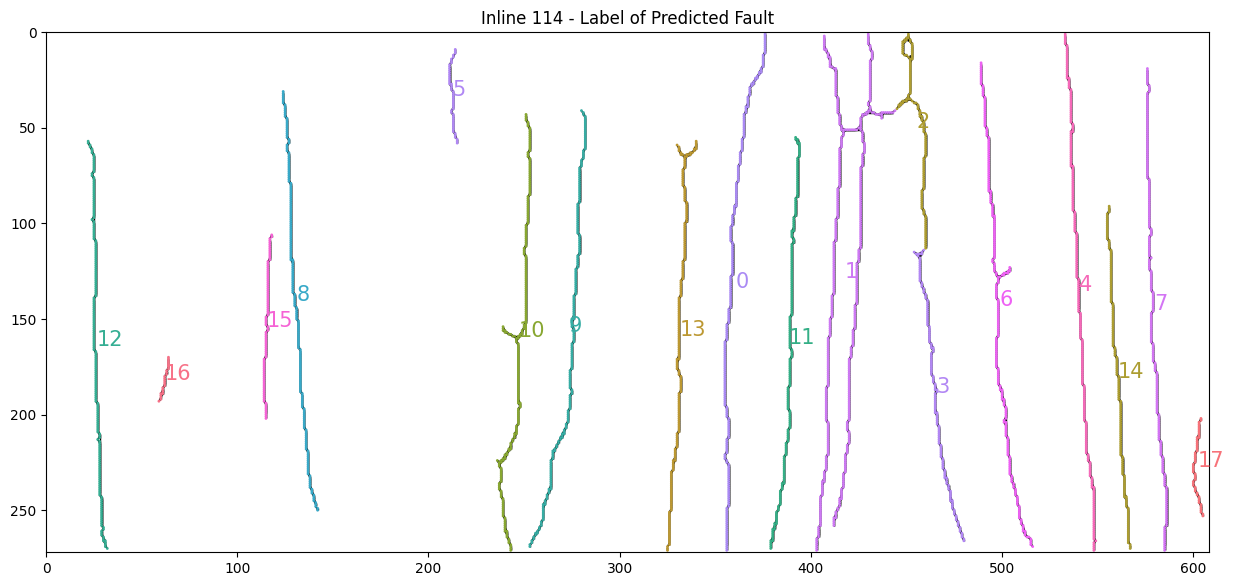

  0%|          | 0/33 [00:00<?, ?it/s]


AttributeError: 'Graph' object has no attribute 'links'

In [45]:
inline_14 = r'D:\PYTHON\fatbox\fatbox_tutorials\Predicted_fault_data\Kerry_inline_114.png'
a = processing_full(inline_14, plot=True, get_3d_data=True)

In [20]:
b = a[1]
edges=list(b.edges(data=True))

edge_color_list=[]

# a = 0
for e in edges: 
    # a += 1
    if e[2]['length'] <= 2.0:
        # print(e[2]['length'])
        edge_color_list.append('tab:blue')
    else:
        b.remove_edge(*e[:2])

edges_new = list(b.edges(data=True))
# for e in edges: 
#     print(e)
type(edges_new)

list

<function matplotlib.pyplot.show(close=None, block=None)>

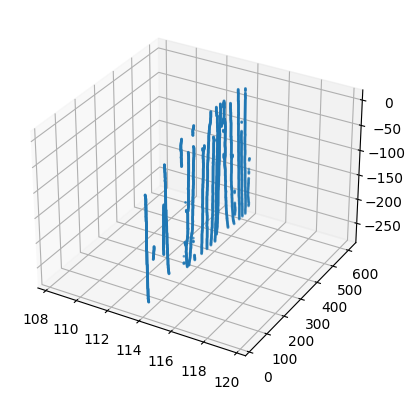

In [51]:
%matplotlib inline

b = a[1]
edges=list(b.nodes(data=True))
x, y, z = [], [], []

for e in edges:
    x.append(e[1]['pos'][0])
    y.append(e[1]['pos'][1])
    z.append(e[1]['pos'][2])
# for e in (edges):
#     x.append(e[0])
#     y.append(e[1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(x), np.array(y), -1*np.array(z), s=1)

for x, y, z in zip(r, s, t):
    ax.plot3D([x, 1.5], [y, 1.5], [z, 1.2], 'b')
plt.show

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos,with_labels=True,edge_color=edge_color_list)

plt.plot([],[],color='tab:blue',label='>='+str(thresh))
plt.legend(loc=0)

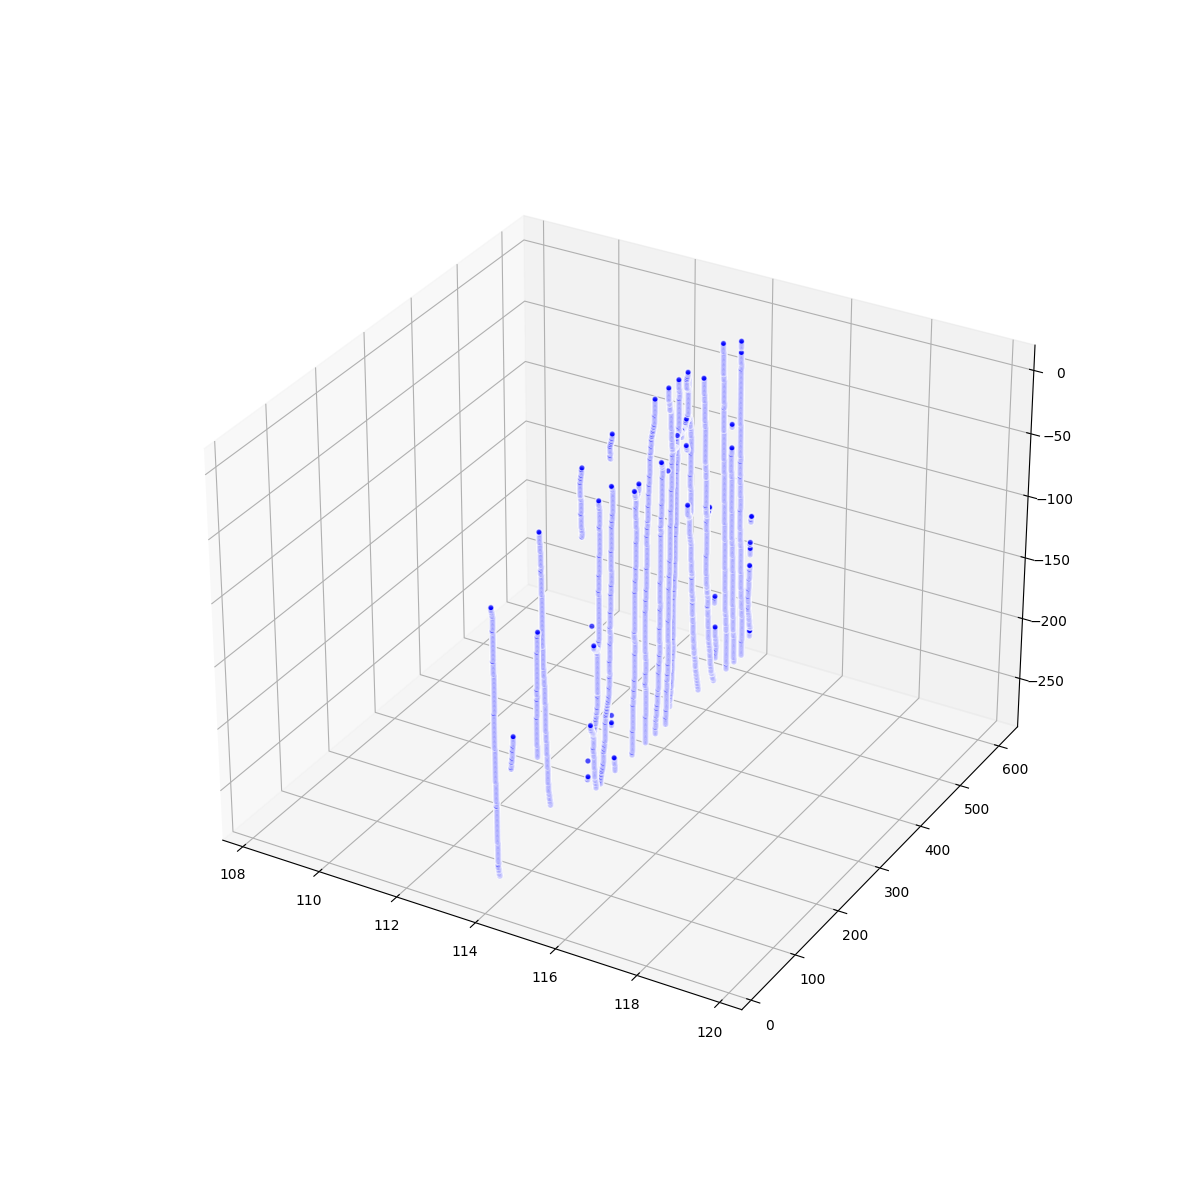

In [5]:
plot_fault_3d(a[1])

Calculate strike: 100%|██████████| 3449/3449 [00:00<00:00, 55631.57it/s]


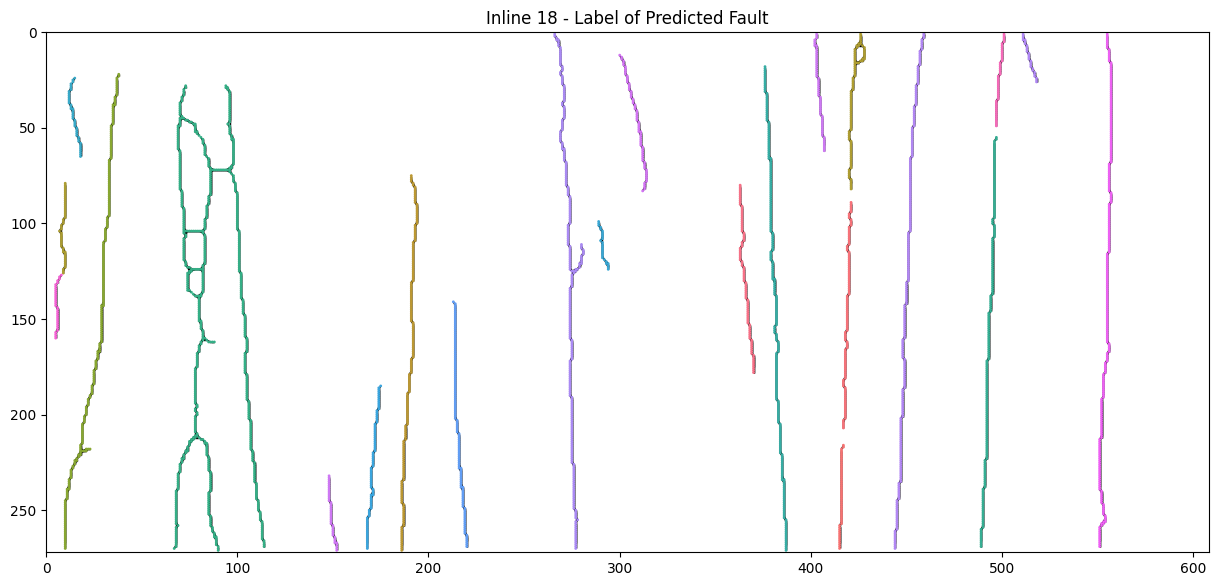

Calculate strike: 100%|██████████| 3206/3206 [00:00<00:00, 57055.68it/s]


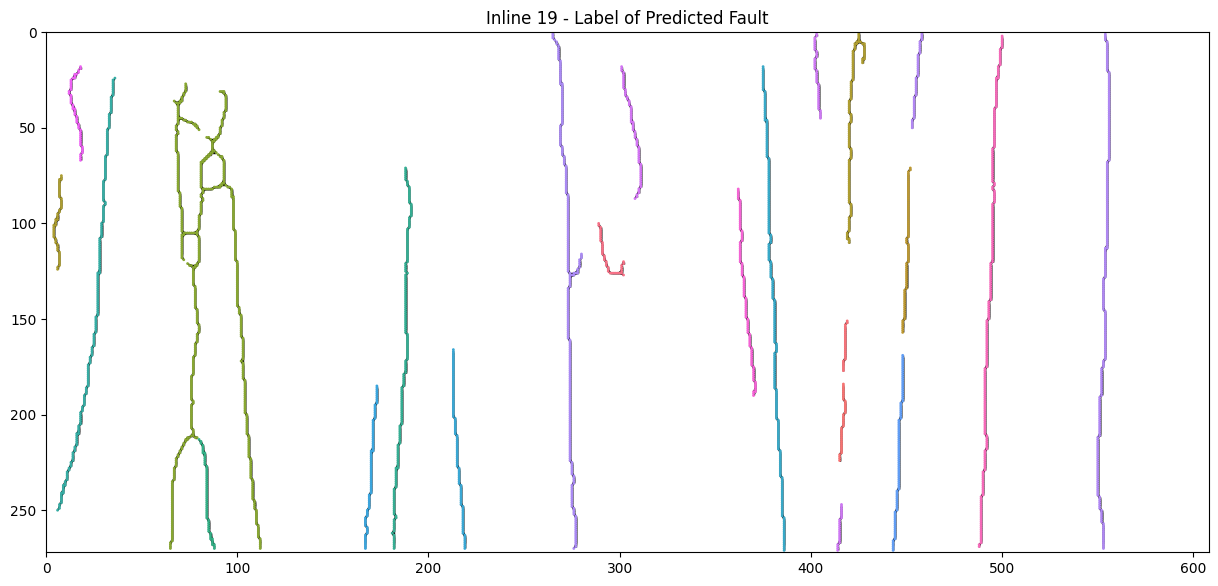

Calculate strike: 100%|██████████| 3182/3182 [00:00<00:00, 58351.52it/s]


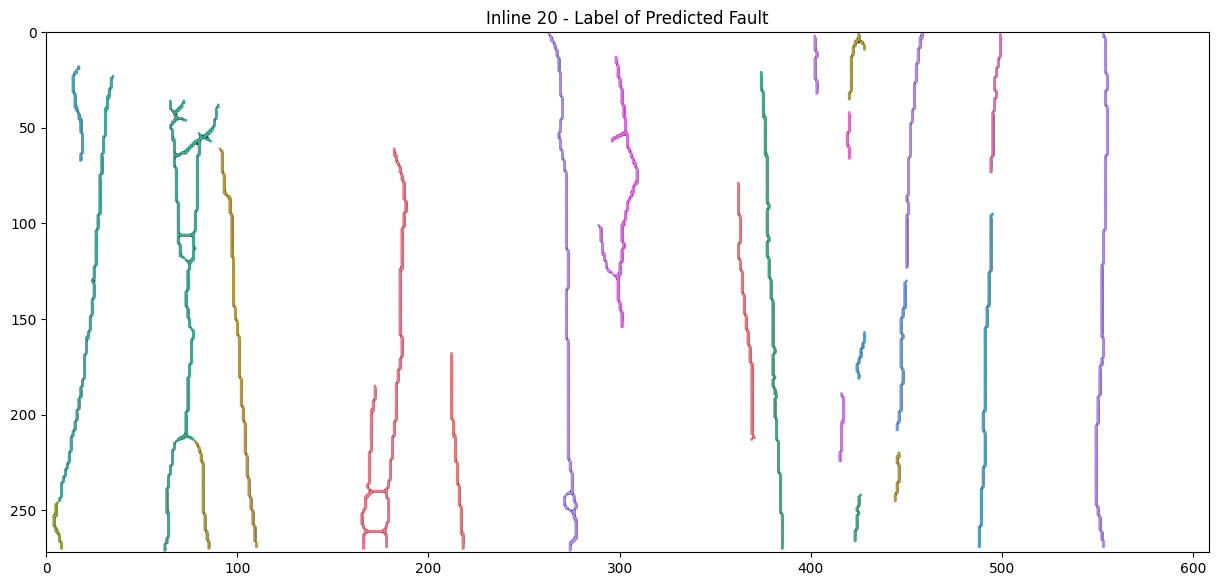

In [85]:
for i in range(18, 21):
    data = f'D:/PYTHON/fatbox/fatbox_tutorials/Predicted_fault_data/Kerry_inline_{i}.png'
    # print(f'inline {data[68:-4]}')
    a = processing_full(data, plot=False, )
    print()

In [71]:
inline_14[68:-4], len(inline_14)

('114', 75)

In [88]:
type(a)

networkx.classes.graph.Graph

In [89]:
b = {}
type(b)

dict